**Introduction to Medical Imaging: Handling Dicom Files**

O Dicom é um formato de arquivo utilizado para armazenar exames médicos, como radiografias, tomografias, ressonâncias magnéticas, entre outros. Ele armazena vários metadados sobre o exame, como dados do paciente, a máquina usada para o exame, como a imagem é armazenada, informações espaciais e assim por diante. Cada exame tem propriedades diferentes, por isso é importante saber com qual tipo de exame você estará lidando em um projeto.

Aqui, mostraremos algumas dicas e truques básicos e essenciais ao manusear um arquivo dicom.


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()
!conda install -c conda-forge gdcm
!pip install pydicom==2.0.0

from google.colab import drive
drive.mount('/content/drive')

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:21
🔁 Restarting kernel...
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.

O segundo passo é usar a biblioteca 'pydicom' para abrir o arquivo dicom desejado. Esta lib retorna um objeto especial com todas as informações armazenadas dentro de um dicom. Para este notebook, usaremos um conjunto de arquivos dicom extraídos do RSNA Pulmonary Embolism Detection Challenge, que estão armazenados na pasta que compartilhamos.

In [ ]:
import pydicom

DATASET_FOLDER = 'drive/MyDrive/Curso IA para Medicina - Cientista de Dados/1. Introdução Imagens Médicas/Dicom Hands-On/sample_train/'
dcm_file = DATASET_FOLDER + '1ac673a65484/43e3fab0e6a7/5fe509226d61.dcm'
dcm = pydicom.dcmread(dcm_file)
print(dcm)

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: "['ORIGINAL', 'PRIMARY', 'AXIAL']"
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: 5fe509226d61
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice Thickness                     DS: "1.25"
(0018, 0060) KVP                                 DS: "120.0"
(0018, 1120) Gantry/Detector Tilt                DS: "0.0"
(0018, 1130) Table Height                        DS: "153.5"
(0018, 1140) Rotation Direction                  CS: 'CW'
(0018, 1151) X-Ray Tube Current                  IS: "367"
(0018, 1152) Exposure                            IS: "3"
(0018, 1210) Convolution Kernel                  SH: 'STANDARD

Aqui podemos ver o que está armazenado dentro de um arquivo dicom. 

Por enquanto, vamos focar nossa atenção na estrela principal: a imagem real do exame. Esta imagem é armazenada no campo "Pixel Data". Como mencionamos anteriormente, pydicom lê um dicom e retorna um objeto especial com diferentes tags dicom. Cada uma dessas tags pode ser acessada como uma variável de objeto normal. Por exemplo, os dados de pixel podem ser acessados ​​usando dcm.PixelData. No entanto, o atributo PixelData armazena os bytes brutos usados ​​para armazenar os pixels da imagem. Existe outro atributo especial que converte o PixelData para um formato mais amigável: o dcm.pixel_array.

Para este primeiro exemplo, usaremos um arquivo dicom de tomografia computadorizada. Portanto, esta imagem representa uma única fatia de um exame 3D. Mas, por enquanto, vamos nos concentrar apenas em como lidar com uma única fatia.

min max img value = (-2000, 4095)
img shape = (512, 512)


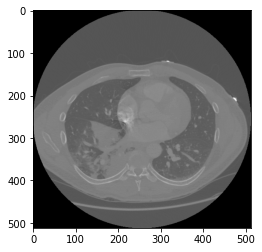

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img = dcm.pixel_array
print(f'min max img value = ({np.min(img)}, {np.max(img)})')
print(f'img shape = {img.shape}')
imgplot = plt.imshow(img, cmap='gray')

**Hounsfield Unit**

Como podemos ver na célula anterior, o pixel_array armazena os valores dos pixels no exame. Observe que, neste caso, os valores de pixel variam de -2000 a 4095 (nesta imagem). Nesta parte, mostramos que cada voxel (voxel é um pixel em um espaço 3D) em uma tomografia computadorizada indica a densidade daquela parte específica do corpo, de forma semelhante a um exame de raio-x. Portanto, valores de pixel mais altos indicam regiões de baixa densidade. Essa medida é realizada com a escala Hounsfield Unit (HU), usada para medir a radiodensidade. Nesta escala, a água destilada tem uma medida de 0 HU, enquanto o ar costuma ficar em torno de -1000 HU. Quando convertemos isso em uma imagem, as regiões de baixa densidade ficam mais escuras, enquanto as áreas de alta densidade são mais claras. Na dicom mostrada na célula anterior, podemos ver um corte mostrando parte dos pulmões do paciente. Os pulmões estão cheios de ar, diminuindo sua densidade. Por isso, é mostrado na imagem com um tom mais escuro.

Mas, na realidade, os arquivos dicom geralmente armazenam a matriz de pixels em uma representação interna. Na verdade, requer uma conversão especial para transformar o valor armazenado na escala de unidade desejada (HU no caso de um exame de TC). Para isso, precisamos de duas outras tags dicom: RescaleSlope e RescaleIntercept. A imagem HU é obtida pela seguinte operação:

\begin{align}
I_{HU} = I r_{s} + r_{i}
\end{align}

onde IHU é a imagem em escala HU, I é a imagem armazenada na matriz de pixels, rs é a etiqueta de inclinação de reescalonamento e ri é a interceptação de reescalonamento

slope = 1.0
intercept = -1024.0
min max img value = (-3024.0, 3071.0)
img shape = (512, 512)


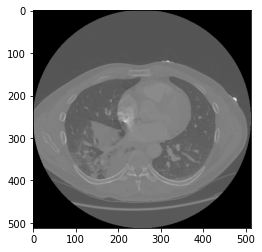

In [ ]:
img = dcm.pixel_array

slope = float(dcm.RescaleSlope)
intercept = float(dcm.RescaleIntercept)
print(f'slope = {slope}')
print(f'intercept = {intercept}')

img = (img*slope +intercept)
print(f'min max img value = ({np.min(img)}, {np.max(img)})')
print(f'img shape = {img.shape}')
imgplot = plt.imshow(img, cmap='gray')

Ao trabalhar com imagens e aprendizado profundo, uma boa coisa a fazer é usar apenas imagens normalizadas. Para imagens de TC, por exemplo, sempre podemos converter uma imagem dicom em um intervalo normalizado entre (0, 1) sem perder nenhuma informação útil:

min max img value = (0.0, 1.0)
img shape = (512, 512)


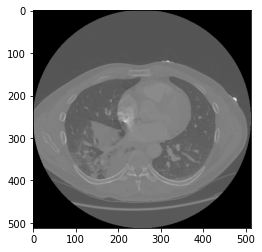

In [ ]:
def change_range(img, new_min, new_max, actual_min=None, actual_max=None):
    if actual_min is None or actual_max is None:
        actual_min = np.min(img)
        actual_max = np.max(img)

    if actual_min == new_min and actual_max == new_max:
        return img

    img = (
        (new_max - new_min) * (img - actual_min) / (actual_max - actual_min)
    ) + new_min

    return img



img = change_range(dcm.pixel_array, new_min=0.0, new_max=1.0)
print(f'min max img value = ({np.min(img)}, {np.max(img)})')
print(f'img shape = {img.shape}')
imgplot = plt.imshow(img, cmap='gray')

**Dicom Windowing Operation**

Uma imagem dicom de um exame de TC ou raio-X são todas representadas na escala da Unidade Hounsfield, que indica a densidade de cada região do corpo. Isso resulta em imagens com muita informação, geralmente representadas por pixels com 12 a 16 bits. Isso é muita informação. Imagens regulares são geralmente representadas com pixels de 8 bits (valores entre (0, 255)). Então, como podemos converter uma imagem dicom medida em HU em uma imagem comum? Bem, já fizemos isso na célula anterior: podemos simplesmente converter esta imagem para um intervalo diferente. Mas ao fazer isso, a imagem se torna uma imagem de baixo contraste, pois há muita informação para nossos olhos capturarem completamente. Uma abordagem mais sofisticada é usar janelas dicom.

Uma janela dicom indica qual faixa do espectro de imagem HU original queremos focar. Uma janela é definida pelos parâmetros principais:

Centro da Janela ( wc ): representa a faixa média de HU a focar;
Largura da janela ( ww ): indica a faixa de HU a partir do centro da janela a ser analisada.
A imagem em janela é calculada de acordo com a seguinte equação:

\begin{align}
min_{p} = w_c - \frac{w_w}{2} \\
max_{p} = w_c + \frac{w_w}{2} \\
I_w = \texttt{clip}(I, min_{p}, max_{p})
\end{align}

onde minp representa o valor mínimo de pixel da imagem em janela, maxp indica o valor máximo de pixel, I é a imagem HU original, Iw é a imagem em janela e clip(i,m,M) é uma função de recorte que recorta todos os valores dentro imagem i para um valor mínimo de m e um valor máximo de M, ou seja, cada pixel com um valor maior que M é recortado em M e todos os valores menores que m são recortados em m.

slope = 1.0
intercept = -1024.0
window_center = 40.0
window_width = 350.0
min max img value = (-135.0, 215.0)


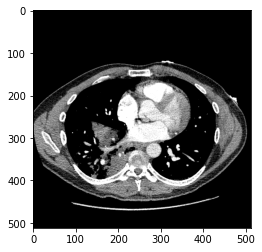

In [ ]:
slope = float(dcm.RescaleSlope)
intercept = float(dcm.RescaleIntercept)
window_center = float(dcm.WindowCenter)
window_width = float(dcm.WindowWidth)
print(f'slope = {slope}')
print(f'intercept = {intercept}')
print(f'window_center = {window_center}')
print(f'window_width = {window_width}')

img = dcm.pixel_array
img = (img*slope +intercept)
img_min = window_center - window_width//2
img_max = window_center + window_width//2
img = np.clip(img, img_min, img_max)

print(f'min max img value = ({np.min(img)}, {np.max(img)})')
imgplot = plt.imshow(img, cmap='gray')



**Building a Compact Windowing Function**

Vamos agora construir uma função compacta capaz de realizar uma operação de janelas sobre uma imagem dicom. Esta função nos permitirá reutilizar esta operação no restante deste curso. Também podemos testar diferentes valores de janela para ver o que muda.

Em primeiro lugar, devemos carregar o arquivo dicom. Já mostramos como carregar um arquivo dicom usando pydicom. Em alguns casos, o atributo de matriz de pixels pode ser compactado dentro do arquivo dicom. Para descompactá-lo, é importante usar a função interna descompactar. Existem vários algoritmos de compactação usados ​​para arquivos dicom. O Pydicom tem alguns algoritmos de descompressão implementados, mas não todos. Para disponibilizar o número máximo de algoritmos de descompressão, recomendamos instalar a biblioteca gdcm (use a versão conda desta biblioteca, pois é mais fácil fazê-la funcionar com a biblioteca pydicom). Se estiver instalado, a função de descompressão funcionará com uma gama mais ampla de algoritmos de descompressão. Usar isso pode salvar seu futuro aprendizado profundo para o pipeline de inferência de imagens médicas.

In [ ]:
import gdcm

def read_dicom(dicom_path):
  ds = pydicom.dcmread(dicom_path)
  ds.decompress()
  return ds

Vamos agora construir uma função para ler as tags dicom de inclinação, interceptação e janela. Como vimos, podemos simplesmente ler essas tags e convertê-las em float. No entanto, isso pode falhar em alguns casos, onde essas tags são armazenadas como uma matriz. Portanto, usamos a seguinte função para recuperar esses valores (função recuperada deste post em uma competição do kaggle):

In [ ]:
def get_first_of_dicom_field_as_int(x):
  if type(x) == pydicom.multival.MultiValue:
    return int(x[0])
  else:
    return int(x)

Agora podemos construir efetivamente nossa função de janelas. Primeiro, devemos carregar o arquivo dicom usando nossa função read_dicom. A segunda coisa que nossa função de janela deve verificar é como os bits são armazenados na imagem dicom. Isso pode ser verificado usando a tag dicom PhotometricInterpretation, que mostra se os valores altos de pixel são convertidos em preto (MONOCHROME1) ou branco (MONOCHROME2). Para mais informações, consulte este e este link. Basicamente, vamos considerar aqui que MONOCHROME2 é o padrão básico a ser seguido, então se alguma dicom for MONOCHROME1, iremos convertê-la para MONOCHROME2 invertendo seu valor.

O restante da função usa conceitos já explorados neste caderno. Se quisermos um conjunto específico de parâmetros de janela, podemos passar esses valores como parâmetros para a função. Caso contrário, usaremos os parâmetros de janela padrão presentes no arquivo dicom.

In [ ]:
def get_single_window_img(path, window_center=None, window_width=None):
  dicom = read_dicom(path)
  img = dicom.pixel_array
  if 'MONOCHROME1' in dicom.PhotometricInterpretation:
    img = 2**dicom.BitsStored-img

  try:
    slope = get_first_of_dicom_field_as_int(dicom.RescaleSlope)
    intercept = get_first_of_dicom_field_as_int(dicom.RescaleIntercept)
    if window_center is None:
      window_center = get_first_of_dicom_field_as_int(dicom.WindowCenter)
      window_width = get_first_of_dicom_field_as_int(dicom.WindowWidth)

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max

    img = (img - img_min) / window_width
  except:
    return None

  return img

**Testing Other Window Parameters**

Com nossa função construída, podemos usá-la para testar diferentes parâmetros de janela. Cada parâmetro de janela é usado para focar a atenção em detalhes específicos da imagem dicom. Por exemplo, o par (centro da janela, largura da janela) usado para analisar os pulmões é (-600, 1500), enquanto uma janela específica do fígado é dada por (30, 150) e uma janela do osso da coluna é (400, 1800) 

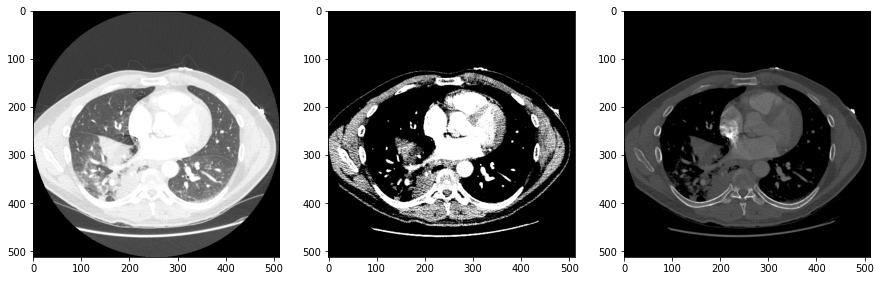

In [ ]:
img_lung = get_single_window_img(dcm_file, window_center=-600, window_width=1500)
img_liver = get_single_window_img(dcm_file, window_center=30, window_width=150)
img_spine = get_single_window_img(dcm_file, window_center=400, window_width=1800)

f, axarr = plt.subplots(1, 3, figsize=(15,15))
axarr[0].imshow(img_lung, cmap='gray')
axarr[1].imshow(img_liver, cmap='gray')
axarr[2].imshow(img_spine, cmap='gray')

Também podemos empilhar essas imagens obtidas usando diferentes parâmetros de janela em uma única imagem. Precisamos apenas adicionar cada imagem a um canal de cor diferente para obter um rgb

(512, 512, 3)


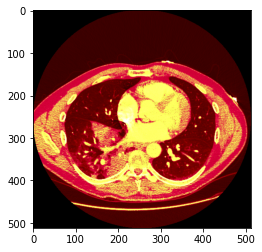

In [ ]:
img = np.stack([img_lung, img_liver, img_spine], axis=-1)
print(img.shape)
imgplot = plt.imshow(img)

Agora podemos encapsular essa operação de construir uma imagem dicom multicanal com diferentes parâmetros de janela em cada canal. Para isso, vamos construir uma função que recebe o caminho do arquivo dicom, uma lista de parâmetros de centro e largura da janela (neste caso, essas listas devem ter o mesmo comprimento), ou um único parâmetro de centro e largura da janela em caso queiramos uma imagem de canal único, ou um valor nulo para ambos os parâmetros caso queiramos carregar os parâmetros originais da janela do dicom.

(512, 512)


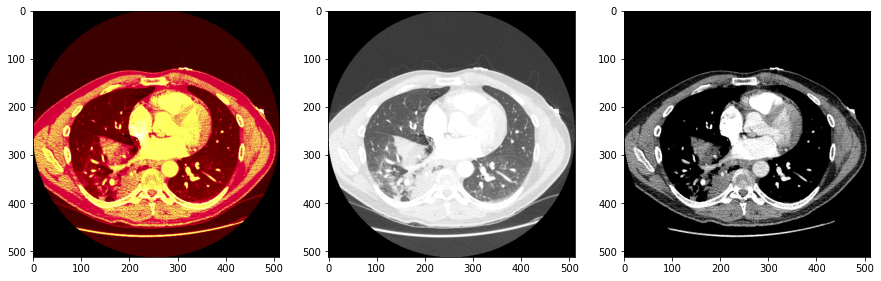

In [ ]:
def get_dicom_img(path, window_center=None, window_width=None):
  img = None
  if window_center is None or window_width is None:
    img = get_single_window_img(path)
  elif type(window_center) == list:
    img = []
    for i in range(len(window_center)):
      img_ch = get_single_window_img(path, window_center[i], window_width[i])
      img.append(img_ch)
    img = np.array(img)
    img = np.moveaxis(img, 0,2)
  else:
    img = get_single_window_img(path, window_center, window_width)

  return img

window_center_list = [-600, 30, 400]
window_width_list = [1500, 150, 1800]
img_multi = get_dicom_img(dcm_file, window_center_list, window_width_list)
img_lung = get_dicom_img(dcm_file, -600, 1500)
img_original = get_dicom_img(dcm_file)

f, axarr = plt.subplots(1, 3, figsize=(15,15))
print(img_original.shape)
axarr[0].imshow(img_multi)
axarr[1].imshow(img_lung, cmap='gray')
axarr[2].imshow(img_original, cmap='gray')